In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


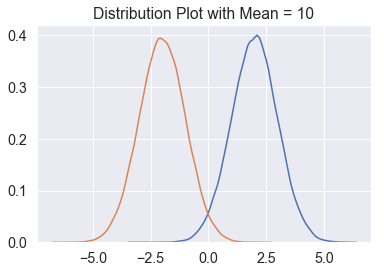

In [9]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False)
sns.distplot(list(zip(*class_neg_one))[0], hist=False)
plt.title("Distribution Plot with Mean = 10")
plt.show()

In [30]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)

cef_estimate(X, y, 300, .32)


0.3980167832513728

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

def calibrated_rf_estimate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, random_state=42)
    clf = RandomForestClassifier(n_estimators = 300)
    clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
    clf_sigmoid.fit(X_train, y_train)
    probs = clf_sigmoid.predict_proba(X_test)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    return np.mean(entropies)

In [34]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    cef = []
    calibrated = []
    sample_sizes = [i*200 for i in range(1, 51)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        X = np.array(X).reshape(-1, 1)
        cef.append(cef_estimate(X, y, 300, .32, depth = 30))
        calibrated.append(calibrated_rf_estimate(X, y))
    return sample_sizes, cef, calibrated

sample_sizes, cef, calibrated = get_cond_entropy_vs_n(1)


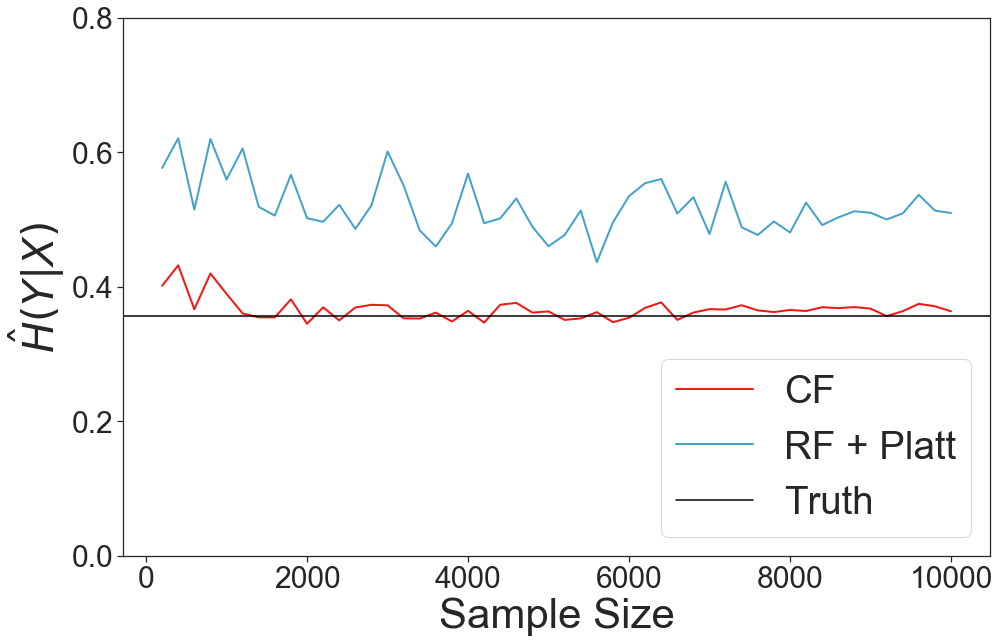

In [38]:
sns.set(font_scale = 3.5)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(sample_sizes, cef, label = "CF", linewidth = 2, color = "#F41711")
plt.plot(sample_sizes, calibrated, label = "RF + Platt", linewidth = 2, color = "#43a2ca")
line_true = plt.axhline(y=.356, linestyle='-', color = "black", label = "Truth")


plt.xlabel("Sample Size")
plt.ylabel("$\hat H(Y|X)$")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.legend(loc = "lower right")
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("calibration_comparison.pdf")
plt.show()